# Adversarial Attack

In [350]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2
from PIL import Image
import pandas as pd

In [352]:
# Metadaten für das Programm 
data = []
labels = []
height = 30
width = 30
channels = 3
classes = 43
input_size = height * width * channels

In [353]:
# Verkehrsschilder 
sign_label = ["20 km/h","30 km/h","50 km/h","60 km/h","70 km/h","80 km/h","80 km/h Aufhebung","100 km/h",
          "120 km/h", "Überholverbot", "LKW-Überholverbot", "Vorfahrt", "Vorfahrtsstraße","Vorfahrt gewähren", 
          "Stop","Fahrverbot","Verbot für Lastwagen","Einfahrt verboten","Gefahr","Linkskurve","Rechtskurve","Doppelkurve",
          "Bodenwelle","Schleudergefahr","Verengung","Baustelle","Ampel","Zebrastreifen","Kinder","Fahrradweg","Schneegefahr",
          "Wildwechsel","Unbegrenzte Geschwindigkeit","Rechtsabbiegen", "Linksabbiegen", "Geradeaus fahren", "Geradeaus oder Rechtsabbiegen",
          "Geradeaus oder Linksabbiegen", "Hindernis rechts umfahren", " Hindernis links umfahren", "Kreisverkehr", "Ende des Überholverbotes",
          "Ende des LKW-Überholverbotes"]

In [354]:
# Laden der Test-Daten CSV
y_test=pd.read_csv(r'.\Test.csv')
names =y_test['Path'].to_numpy()
y_test =y_test['ClassId'].values
data=[]

In [355]:
# Laden der Test-Daten Bilder
from tqdm import tqdm
for f in tqdm(names):
    image=cv2.imread(r'.\Test/'+f.replace('Test', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

100%|██████████| 12630/12630 [00:18<00:00, 672.32it/s]


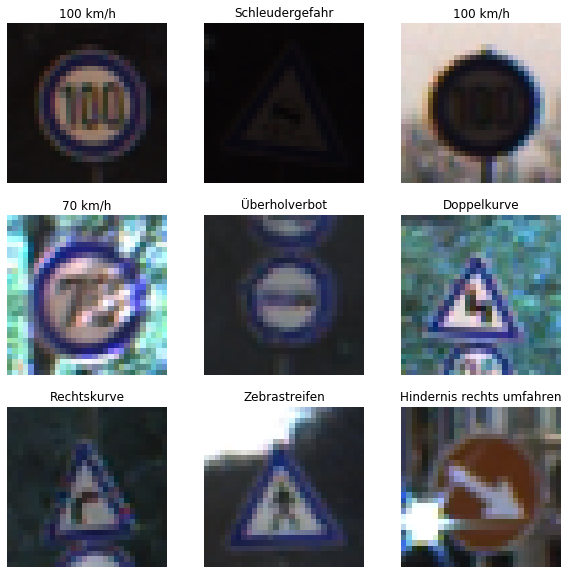

In [356]:
# Beispiele aus dem Test Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    x = i+10
    fig.add_subplot(rows, columns, i)
    plt.imshow(data[x])
    plt.title(sign_label[y_test[x]])
    plt.axis("off")
plt.show()

In [357]:
model = keras.models.load_model("Traffic_Sign_Net")

In [358]:
x_test=np.array(data)
x_test = x_test.astype('float32')/255
pred = model.predict(x_test)
print("Anzahlder Predictions:",len(pred))

Anzahlder Predictions: 12630


# Attacke FGSM

In [359]:
# Funktion um ein adversarial_pattern zu erstellen
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

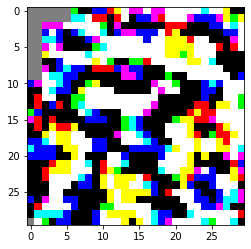

In [360]:
# Darstellung des Patterns 
i = 408 #408, 7, 10, 14

image = x_test[i]
image = image.reshape(1, height, width, channels)

image_label = y_test[i]
image_probs = model.predict(image)

label = tf.one_hot(image_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [361]:
max_iterations = 1.0
confidence = 0.9

for x in np.arange(0.0, max_iterations, 0.001):
    
    adversarial = image + perturbations * x
    adversarial = tf.clip_by_value(adversarial, -1, 1)
    
    original_prediction = sign_label[model.predict(image).argmax()]
    adversarial_prediction = sign_label[model.predict(adversarial).argmax()]
    
    print("Noise:", round(x,3), 
          "\t Confidence",round(max(model.predict(adversarial)[0]), 3),
          "\t Prediction",adversarial_prediction)
    
    if original_prediction != adversarial_prediction and \
    max(model.predict(adversarial)[0]) > confidence:
        noise = x
        break

Noise: 0.0 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.001 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.002 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.003 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.004 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.005 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.006 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.007 	 Confidence 0.999 	 Prediction 80 km/h
Noise: 0.008 	 Confidence 0.998 	 Prediction 80 km/h
Noise: 0.009 	 Confidence 0.994 	 Prediction 80 km/h
Noise: 0.01 	 Confidence 0.983 	 Prediction 80 km/h
Noise: 0.011 	 Confidence 0.949 	 Prediction 80 km/h
Noise: 0.012 	 Confidence 0.865 	 Prediction 80 km/h
Noise: 0.013 	 Confidence 0.718 	 Prediction 80 km/h
Noise: 0.014 	 Confidence 0.511 	 Prediction 80 km/h
Noise: 0.015 	 Confidence 0.67 	 Prediction 60 km/h
Noise: 0.016 	 Confidence 0.794 	 Prediction 60 km/h
Noise: 0.017 	 Confidence 0.88 	 Prediction 60 km/h
Noise: 0.018 	 Confidence 0.931 	 Prediction 60 km/h


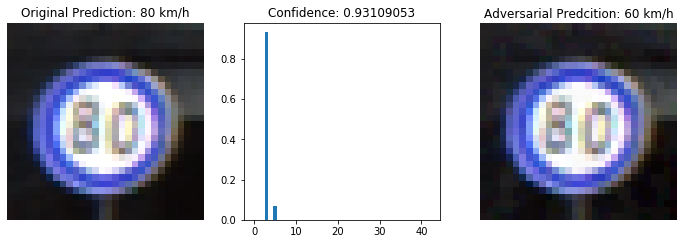

In [362]:
# Ergebnisse der Attacke darstellen
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

y = [i for i in range(len(sign_label))]

ax1.imshow(image[0])
ax2.bar(y, model.predict(adversarial)[0])
ax3.imshow(adversarial[0])

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Prediction: "+str(original_prediction))
ax2.title.set_text("Confidence: "+ str(max(model.predict(adversarial)[0])))
ax3.title.set_text("Adversarial Predcition: " + str(adversarial_prediction))
plt.show()

# Rescaling

In [363]:
def rescaler(image, size):
    image_reshaped = image.reshape(height, width, channels)
    image_from_array = Image.fromarray(image_reshaped, 'RGB')
    size_image = image_from_array.resize((size, size))
    image_array = np.array(size_image)
    return image_array

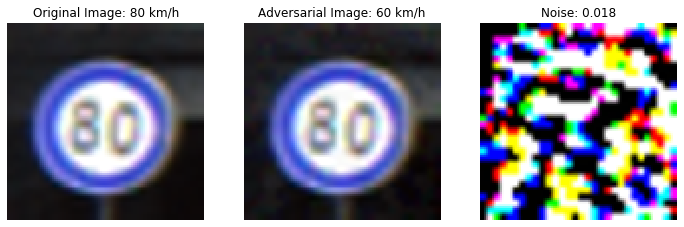

In [364]:
# Ergebnisse der Attacke darstellen
adversarial_image = adversarial.numpy()
adversarial_image = adversarial_image * 255
adversarial_image = adversarial_image.astype('uint8')
adversarial_image = rescaler(adversarial_image, 100)

perturbations_pattern = perturbations.numpy()
perturbations_pattern = perturbations_pattern * 255
perturbations_pattern = perturbations_pattern.astype('uint8')
perturbations_pattern = rescaler(perturbations_pattern, 100)

original_image = image
original_image = original_image * 255
original_image = original_image.astype('uint8')
original_image = rescaler(original_image, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

ax1.imshow(original_image)
ax2.imshow(adversarial_image)
ax3.imshow(perturbations_pattern)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Image: "+str(original_prediction))
ax2.title.set_text("Adversarial Image: "+ str(adversarial_prediction))
ax3.title.set_text("Noise: " + str(round(noise,3)))
plt.show()

# Downscaling

In [ ]:
def downscaler(image):
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    array_image = np.array(size_image)
    array_image = array_image.astype('float32')/255
    array_image = array_image.reshape(1, height, width, channels)
    return array_image


In [378]:
adversarial_down_image = downscaler(adversarial_image)
print("Vorhersage für das neu skallierte Bild:",\
      sign_label[model.predict(adversarial_down_image).argmax()])

Vorhersage für das neu skallierte Bild: 60 km/h


# Meta Daten

In [370]:
# Laden der Meta Daten 
meta_data=[]
for f in range(42):
    image=cv2.imread("./Meta/"+str(f)+".png")
    image_from_array = Image.fromarray(image, 'RGB')
    meta_data.append(np.array(image_from_array)) 

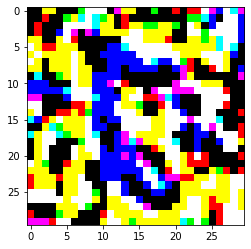

In [383]:
meta_image = downscaler(meta_data[14])

image = meta_image
image = image.reshape(1, height, width, channels)

image_label = y_test[i]
image_probs = model.predict(image)

label = tf.one_hot(image_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [384]:
max_iterations = 1.0
confidence = 0.9

for x in np.arange(0.0, max_iterations, 0.001):
    
    adversarial = image + perturbations * x
    adversarial = tf.clip_by_value(adversarial, -1, 1)
    
    original_prediction = sign_label[model.predict(image).argmax()]
    adversarial_prediction = sign_label[model.predict(adversarial).argmax()]
    
    print("Noise:", round(x,3), 
          "\t Confidence",round(max(model.predict(adversarial)[0]), 3),
          "\t Prediction",adversarial_prediction)
    
    if original_prediction != adversarial_prediction and \
    max(model.predict(adversarial)[0]) > confidence:
        noise = x
        break

Noise: 0.0 	 Confidence 1.0 	 Prediction Stop
Noise: 0.001 	 Confidence 1.0 	 Prediction Stop
Noise: 0.002 	 Confidence 1.0 	 Prediction Stop
Noise: 0.003 	 Confidence 1.0 	 Prediction Stop
Noise: 0.004 	 Confidence 1.0 	 Prediction Stop
Noise: 0.005 	 Confidence 1.0 	 Prediction Stop
Noise: 0.006 	 Confidence 1.0 	 Prediction Stop
Noise: 0.007 	 Confidence 1.0 	 Prediction Stop
Noise: 0.008 	 Confidence 1.0 	 Prediction Stop
Noise: 0.009 	 Confidence 1.0 	 Prediction Stop
Noise: 0.01 	 Confidence 1.0 	 Prediction Stop
Noise: 0.011 	 Confidence 1.0 	 Prediction Stop
Noise: 0.012 	 Confidence 1.0 	 Prediction Stop
Noise: 0.013 	 Confidence 1.0 	 Prediction Stop
Noise: 0.014 	 Confidence 1.0 	 Prediction Stop
Noise: 0.015 	 Confidence 1.0 	 Prediction Stop
Noise: 0.016 	 Confidence 1.0 	 Prediction Stop
Noise: 0.017 	 Confidence 1.0 	 Prediction Stop
Noise: 0.018 	 Confidence 1.0 	 Prediction Stop
Noise: 0.019 	 Confidence 1.0 	 Prediction Stop
Noise: 0.02 	 Confidence 1.0 	 Prediction S

Noise: 0.172 	 Confidence 1.0 	 Prediction Stop
Noise: 0.173 	 Confidence 1.0 	 Prediction Stop
Noise: 0.174 	 Confidence 1.0 	 Prediction Stop
Noise: 0.175 	 Confidence 1.0 	 Prediction Stop
Noise: 0.176 	 Confidence 1.0 	 Prediction Stop
Noise: 0.177 	 Confidence 1.0 	 Prediction Stop
Noise: 0.178 	 Confidence 1.0 	 Prediction Stop
Noise: 0.179 	 Confidence 1.0 	 Prediction Stop
Noise: 0.18 	 Confidence 1.0 	 Prediction Stop
Noise: 0.181 	 Confidence 1.0 	 Prediction Stop
Noise: 0.182 	 Confidence 1.0 	 Prediction Stop
Noise: 0.183 	 Confidence 1.0 	 Prediction Stop
Noise: 0.184 	 Confidence 1.0 	 Prediction Stop
Noise: 0.185 	 Confidence 1.0 	 Prediction Stop
Noise: 0.186 	 Confidence 1.0 	 Prediction Stop
Noise: 0.187 	 Confidence 1.0 	 Prediction Stop
Noise: 0.188 	 Confidence 1.0 	 Prediction Stop
Noise: 0.189 	 Confidence 1.0 	 Prediction Stop
Noise: 0.19 	 Confidence 1.0 	 Prediction Stop
Noise: 0.191 	 Confidence 1.0 	 Prediction Stop
Noise: 0.192 	 Confidence 1.0 	 Prediction

Noise: 0.344 	 Confidence 1.0 	 Prediction Stop
Noise: 0.345 	 Confidence 1.0 	 Prediction Stop
Noise: 0.346 	 Confidence 1.0 	 Prediction Stop
Noise: 0.347 	 Confidence 1.0 	 Prediction Stop
Noise: 0.348 	 Confidence 1.0 	 Prediction Stop
Noise: 0.349 	 Confidence 1.0 	 Prediction Stop
Noise: 0.35 	 Confidence 1.0 	 Prediction Stop
Noise: 0.351 	 Confidence 1.0 	 Prediction Stop
Noise: 0.352 	 Confidence 1.0 	 Prediction Stop
Noise: 0.353 	 Confidence 1.0 	 Prediction Stop
Noise: 0.354 	 Confidence 1.0 	 Prediction Stop
Noise: 0.355 	 Confidence 1.0 	 Prediction Stop
Noise: 0.356 	 Confidence 1.0 	 Prediction Stop
Noise: 0.357 	 Confidence 1.0 	 Prediction Stop
Noise: 0.358 	 Confidence 1.0 	 Prediction Stop
Noise: 0.359 	 Confidence 1.0 	 Prediction Stop
Noise: 0.36 	 Confidence 1.0 	 Prediction Stop
Noise: 0.361 	 Confidence 1.0 	 Prediction Stop
Noise: 0.362 	 Confidence 1.0 	 Prediction Stop
Noise: 0.363 	 Confidence 1.0 	 Prediction Stop
Noise: 0.364 	 Confidence 1.0 	 Prediction

Noise: 0.518 	 Confidence 1.0 	 Prediction Stop
Noise: 0.519 	 Confidence 1.0 	 Prediction Stop
Noise: 0.52 	 Confidence 1.0 	 Prediction Stop
Noise: 0.521 	 Confidence 1.0 	 Prediction Stop
Noise: 0.522 	 Confidence 1.0 	 Prediction Stop
Noise: 0.523 	 Confidence 1.0 	 Prediction Stop
Noise: 0.524 	 Confidence 1.0 	 Prediction Stop
Noise: 0.525 	 Confidence 1.0 	 Prediction Stop
Noise: 0.526 	 Confidence 1.0 	 Prediction Stop
Noise: 0.527 	 Confidence 1.0 	 Prediction Stop
Noise: 0.528 	 Confidence 1.0 	 Prediction Stop
Noise: 0.529 	 Confidence 1.0 	 Prediction Stop
Noise: 0.53 	 Confidence 1.0 	 Prediction Stop
Noise: 0.531 	 Confidence 1.0 	 Prediction Stop
Noise: 0.532 	 Confidence 1.0 	 Prediction Stop
Noise: 0.533 	 Confidence 1.0 	 Prediction Stop
Noise: 0.534 	 Confidence 1.0 	 Prediction Stop
Noise: 0.535 	 Confidence 1.0 	 Prediction Stop
Noise: 0.536 	 Confidence 1.0 	 Prediction Stop
Noise: 0.537 	 Confidence 1.0 	 Prediction Stop
Noise: 0.538 	 Confidence 1.0 	 Prediction

Noise: 0.69 	 Confidence 1.0 	 Prediction Stop
Noise: 0.691 	 Confidence 1.0 	 Prediction Stop
Noise: 0.692 	 Confidence 1.0 	 Prediction Stop
Noise: 0.693 	 Confidence 1.0 	 Prediction Stop
Noise: 0.694 	 Confidence 1.0 	 Prediction Stop
Noise: 0.695 	 Confidence 1.0 	 Prediction Stop
Noise: 0.696 	 Confidence 1.0 	 Prediction Stop
Noise: 0.697 	 Confidence 1.0 	 Prediction Stop
Noise: 0.698 	 Confidence 1.0 	 Prediction Stop
Noise: 0.699 	 Confidence 1.0 	 Prediction Stop
Noise: 0.7 	 Confidence 1.0 	 Prediction Stop
Noise: 0.701 	 Confidence 1.0 	 Prediction Stop
Noise: 0.702 	 Confidence 1.0 	 Prediction Stop
Noise: 0.703 	 Confidence 1.0 	 Prediction Stop
Noise: 0.704 	 Confidence 1.0 	 Prediction Stop
Noise: 0.705 	 Confidence 1.0 	 Prediction Stop
Noise: 0.706 	 Confidence 1.0 	 Prediction Stop
Noise: 0.707 	 Confidence 1.0 	 Prediction Stop
Noise: 0.708 	 Confidence 1.0 	 Prediction Stop
Noise: 0.709 	 Confidence 1.0 	 Prediction Stop
Noise: 0.71 	 Confidence 1.0 	 Prediction S

Noise: 0.864 	 Confidence 1.0 	 Prediction Stop
Noise: 0.865 	 Confidence 1.0 	 Prediction Stop
Noise: 0.866 	 Confidence 1.0 	 Prediction Stop
Noise: 0.867 	 Confidence 1.0 	 Prediction Stop
Noise: 0.868 	 Confidence 1.0 	 Prediction Stop
Noise: 0.869 	 Confidence 1.0 	 Prediction Stop
Noise: 0.87 	 Confidence 1.0 	 Prediction Stop
Noise: 0.871 	 Confidence 1.0 	 Prediction Stop
Noise: 0.872 	 Confidence 1.0 	 Prediction Stop
Noise: 0.873 	 Confidence 1.0 	 Prediction Stop
Noise: 0.874 	 Confidence 1.0 	 Prediction Stop
Noise: 0.875 	 Confidence 1.0 	 Prediction Stop
Noise: 0.876 	 Confidence 1.0 	 Prediction Stop
Noise: 0.877 	 Confidence 1.0 	 Prediction Stop
Noise: 0.878 	 Confidence 1.0 	 Prediction Stop
Noise: 0.879 	 Confidence 1.0 	 Prediction Stop
Noise: 0.88 	 Confidence 1.0 	 Prediction Stop
Noise: 0.881 	 Confidence 1.0 	 Prediction Stop
Noise: 0.882 	 Confidence 1.0 	 Prediction Stop
Noise: 0.883 	 Confidence 1.0 	 Prediction Stop
Noise: 0.884 	 Confidence 1.0 	 Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


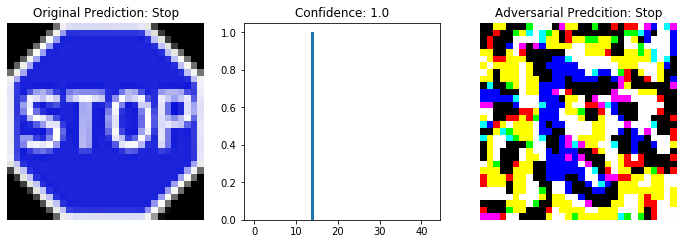

In [385]:
# Ergebnisse der Attacke darstellen
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

y = [i for i in range(len(sign_label))]

ax1.imshow(image[0])
ax2.bar(y, model.predict(adversarial)[0])
ax3.imshow(adversarial[0])

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Prediction: "+str(original_prediction))
ax2.title.set_text("Confidence: "+ str(max(model.predict(adversarial)[0])))
ax3.title.set_text("Adversarial Predcition: " + str(adversarial_prediction))
plt.show()